## Test on a simple case
Consider the following Possion Equation
$$
\begin{cases}
    \Delta u = 1\qquad &u\in\Omega\\
    u = 0\qquad &u\in\partial\Omega.
\end{cases}$$
Here $\Omega = \{(x, y)|x^2+y^2 < 1\}$

The exact solution to this problem is $$u = \frac{1}{4}(x^2+y^2-1).$$

In [12]:
% matplotlib inline
import torch 
import torch.nn.functional as F
import numpy as np
from math import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm

torch.set_default_tensor_type('torch.FloatTensor')

m = 10
learning_rate = 0.01
iterations = 400  #default 10000
print_every_iter = 100
beta = 500 #coefficient for the regularization term in the loss expression, is set to be 1000 in section 3.1
n1 = 1000 #number of points in (0,1)^m
n2 = 100  #number of points on the border of (0,1)^m
n3 = 100  #number of points used for evaluating the error

class DeepRitzNet(torch.nn.Module):
    def __init__(self, m):
        super(DeepRitzNet, self).__init__()
        self.linear1 = torch.nn.Linear(m,m)
        self.linear2 = torch.nn.Linear(m,m)
        self.linear3 = torch.nn.Linear(m,m)
        self.linear4 = torch.nn.Linear(m,m)
        self.linear5 = torch.nn.Linear(m,m)
        self.linear6 = torch.nn.Linear(m,m)
        
        self.linear7 = torch.nn.Linear(m,1)
    
    def forward(self, x):
        y = x
        y = y + F.relu(self.linear2(F.relu(self.linear1(y))))
        y = y + F.relu(self.linear4(F.relu(self.linear3(y))))
        y = y + F.relu(self.linear6(F.relu(self.linear5(y))))
        output = F.relu(self.linear7(y))
        return output

In [26]:
def draw_graph(mod):
    points = np.arange(-1, 1, 0.01)
    xs, ys = np.meshgrid(points, points)
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    xl, yl = xs.size()
    z = np.zeros((xl, yl))
    for i in range(xl):
        for j in range(yl):      
            re = np.zeros(m)
            re[0] = xs[i, j]
            re[1] = ys[i, j]
            re = torch.tensor(re)        
            z[i, j] = mod(re.float()).item() + U_groundtruth(re)
    
    plt.imshow(z, cmap=cm.hot)
    plt.colorbar()
    
    #plt.savefig("loss_1.eps")
    plt.show()

In [40]:
def cal_loss(mod):
    points = np.arange(-1, 1, 0.1)
    xs, ys = np.meshgrid(points, points)
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    xl, yl = xs.size()
    z = np.zeros((xl, yl))
    mmm = 0
    t = 0
    for i in range(xl):
        for j in range(yl):      
            re = np.zeros(m)
            re[0] = xs[i, j]
            re[1] = ys[i, j]
            re = torch.tensor(re)        
            z[i, j] = mod(re.float()).item() + U_groundtruth(re)
            #?????????
            if re[0] ** 2 + re[1] ** 2 < 1 : 
                mmm += abs(z[i, j])
                t = t + 1
    
    return mmm / t

In [17]:
#U_groundtruth = 1/4*(x^2+y^2)-1/4
#take in a (m,) tensor (x, y, ...)
def U_groundtruth(t):
    #re = 0
    re = (t[0] ** 2 + t[1] ** 2 - 1).item() / 4
    return re

def on_sample(m):
    theta = np.random.rand() * 2 * pi
    a = np.linspace(0, 2*pi, 100)
    
    re = np.zeros(m)
    re[0] = cos(theta)
    re[1] = sin(theta)
    re = torch.tensor(re, requires_grad=True)
    return re

In [31]:
"""
Train with the grid
"""
gamma = 100
model = DeepRitzNet(m)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
in_error_iter = [] #record the error in Omega every print_every_iter=100 times
on_error_iter = [] #record the error on the border of Omega every print_every_iter=100 times

mm = 1
points = np.arange(-1, 1, 0.1)
xs, ys = np.meshgrid(points, points)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
xl, yl = xs.size()
                
lr1 = 0.01
lr2 = 0.003
optimizer1 = torch.optim.Adam(model.parameters(), lr=lr1)
optimizer2 = torch.optim.Adam(model.parameters(), lr=lr2)
ccc = 1
for k in range(400):
    loss = torch.zeros(1)
    for i in range(xl):
        for j in range(yl):        
            x_input = np.zeros(m)
            x_input[0] = xs[i, j]
            x_input[1] = ys[i, j]
            if x_input[0] ** 2 + x_input[1] ** 2 < 1:
                x_input = torch.tensor(x_input).float()
                y = model(x_input)
                
                x1 = torch.zeros(m)
                x2 = torch.zeros(m)
                x1[0] = 0.0001
                x2[1] = 0.0001
                x_input_1 = x_input.float() + x1
                x_input_2 = x_input.float() + x2
                x_input_3 = x_input.float() - x1
                x_input_4 = x_input.float() - x2
                x_input_grad_1 = (model(x_input_1) - y) / 0.0001
                x_input_grad_2 = (model(x_input_2) - y) / 0.0001
                x_input_2_grad_x = (model(x_input_1) + model(x_input_3) - 2 * y) / 0.0001**2
                x_input_2_grad_y = (model(x_input_2) + model(x_input_4) - 2 * y) / 0.0001**2

                loss += 0.5 * ((x_input_grad_1) ** 2 + (x_input_grad_2) ** 2) - y
                #loss += 0.5 * ((x_input.grad.float()[0]) ** 2 + (x_input.grad.float()[1]) ** 2) + y
                
    loss /= (xl * yl)
    
    regularization = torch.zeros(1)
    
    grid = np.linspace(0, 2*pi, 200)
    n2 = 1
    for i in range(200):
        if i < 199:
            grid_i_1 = grid[i+1]
        else:
            grid_i_1 = grid[0]
        th = (grid[i] + grid_i_1) / 2
        x1 = np.zeros(m)
        x1[0] = cos(th)
        x1[1] = sin(th)
        x1 = torch.tensor(x1).float()
        yy = model(x1)
        t = floor(abs(yy)*100)
        for theta in np.linspace(grid[i], grid_i_1, t):
            x_input = np.zeros(m)
            x_input[0] = cos(theta)
            x_input[1] = sin(theta)
            x_input = torch.tensor(x_input).float()
            y = model(x_input)
            regularization += y**2 
            n2 = n2 + 1
    regularization *= mm / n2
    if mm < 500:
        mm = mm * 1.015
        
    #print loss
    print(k, " epoch, loss: ", loss.data[0].numpy())
    print(k, " epoch, regularization loss: ", regularization.data[0].numpy())
    cal_l = cal_loss(model)
    print(k, " loss to real solution: ", cal_l)
    if cal_l < ccc:
        mod = model
        ccc = cal_l
    
    loss += regularization
    
    #and step the optimizer
    optimizer1.zero_grad()
    optimizer2.zero_grad()
    loss.backward()
    if k < 150:
        optimizer1.step()
    else:
        optimizer2.step()

0  epoch, loss:  -0.07752536982297897
0  epoch, regularization loss:  0.12735500931739807
0  loss to real solution:  0.126099881044
1  epoch, loss:  -0.047005943953990936
1  epoch, regularization loss:  0.060254912823438644
1  loss to real solution:  0.110796069378
2  epoch, loss:  -0.025038648396730423
2  epoch, regularization loss:  0.023693149909377098
2  loss to real solution:  0.109888496172
3  epoch, loss:  -0.015646392479538918
3  epoch, regularization loss:  0.010618352331221104
3  loss to real solution:  0.111793016834
4  epoch, loss:  -0.018377330154180527
4  epoch, regularization loss:  0.010273179039359093
4  loss to real solution:  0.107083689285
5  epoch, loss:  -0.03891128674149513
5  epoch, regularization loss:  0.013856935314834118
5  loss to real solution:  0.0861779795295
6  epoch, loss:  -0.08076879382133484
6  epoch, regularization loss:  0.021407315507531166
6  loss to real solution:  0.0621902751788
7  epoch, loss:  -0.12837515771389008
7  epoch, regularization l

62  epoch, loss:  -0.1593860685825348
62  epoch, regularization loss:  0.05912267789244652
62  loss to real solution:  0.135131927401
63  epoch, loss:  -0.16239072382450104
63  epoch, regularization loss:  0.06515946239233017
63  loss to real solution:  0.136713368185
64  epoch, loss:  -0.1584119349718094
64  epoch, regularization loss:  0.05979050695896149
64  loss to real solution:  0.130820020311
65  epoch, loss:  -0.14919249713420868
65  epoch, regularization loss:  0.049016326665878296
65  loss to real solution:  0.119919420075
66  epoch, loss:  -0.1417851746082306
66  epoch, regularization loss:  0.043881386518478394
66  loss to real solution:  0.111437131758
67  epoch, loss:  -0.1412644237279892
67  epoch, regularization loss:  0.0456499345600605
67  loss to real solution:  0.11164049387
68  epoch, loss:  -0.1496649980545044
68  epoch, regularization loss:  0.05160188674926758
68  loss to real solution:  0.119755437564
69  epoch, loss:  -0.16290754079818726
69  epoch, regulariza

122  epoch, loss:  -0.06650117039680481
122  epoch, regularization loss:  0.019275318831205368
122  loss to real solution:  0.0212620199359
123  epoch, loss:  -0.06181490793824196
123  epoch, regularization loss:  0.010408781468868256
123  loss to real solution:  0.0182917212654
124  epoch, loss:  -0.0714043378829956
124  epoch, regularization loss:  0.013393588364124298
124  loss to real solution:  0.0204277614075
125  epoch, loss:  -0.09899295121431351
125  epoch, regularization loss:  0.04413332790136337
125  loss to real solution:  0.0447076612213
126  epoch, loss:  -0.10801427066326141
126  epoch, regularization loss:  0.06282898038625717
126  loss to real solution:  0.0547197168337
127  epoch, loss:  -0.09511329978704453
127  epoch, regularization loss:  0.045778799802064896
127  loss to real solution:  0.0401517556009
128  epoch, loss:  -0.0743466392159462
128  epoch, regularization loss:  0.020695440471172333
128  loss to real solution:  0.024118793555
129  epoch, loss:  -0.060

181  epoch, loss:  -0.0654505044221878
181  epoch, regularization loss:  0.012553217820823193
181  loss to real solution:  0.017355318102
182  epoch, loss:  -0.06125330924987793
182  epoch, regularization loss:  0.008938426151871681
182  loss to real solution:  0.0135286683112
183  epoch, loss:  -0.05734800919890404
183  epoch, regularization loss:  0.008022468537092209
183  loss to real solution:  0.00993164220424
184  epoch, loss:  -0.05712758004665375
184  epoch, regularization loss:  0.0077583277598023415
184  loss to real solution:  0.00960471796453
185  epoch, loss:  -0.06188760697841644
185  epoch, regularization loss:  0.010776717215776443
185  loss to real solution:  0.0124543990046
186  epoch, loss:  -0.06573262065649033
186  epoch, regularization loss:  0.01563790813088417
186  loss to real solution:  0.0153464676598
187  epoch, loss:  -0.0640404224395752
187  epoch, regularization loss:  0.013756101951003075
187  loss to real solution:  0.0130157356362
188  epoch, loss:  -0

240  epoch, loss:  -0.04703204706311226
240  epoch, regularization loss:  0.005728728603571653
240  loss to real solution:  0.0135670755684
241  epoch, loss:  -0.045554131269454956
241  epoch, regularization loss:  0.004437334835529327
241  loss to real solution:  0.0144797042003
242  epoch, loss:  -0.04483882337808609
242  epoch, regularization loss:  0.00392440240830183
242  loss to real solution:  0.0152553692163
243  epoch, loss:  -0.04445372521877289
243  epoch, regularization loss:  0.0016062392387539148
243  loss to real solution:  0.015563751852
244  epoch, loss:  -0.046592555940151215
244  epoch, regularization loss:  0.004423778969794512
244  loss to real solution:  0.0137705034037
245  epoch, loss:  -0.04724518209695816
245  epoch, regularization loss:  0.005814897827804089
245  loss to real solution:  0.0127840859484
246  epoch, loss:  -0.04643232747912407
246  epoch, regularization loss:  0.0053560687229037285
246  loss to real solution:  0.0130331165518
247  epoch, loss: 

302  epoch, loss:  -0.03412454575300217
302  epoch, regularization loss:  0.010164567269384861
302  loss to real solution:  0.0311651442672
303  epoch, loss:  -0.03713240474462509
303  epoch, regularization loss:  0.01384921744465828
303  loss to real solution:  0.0255603574346
304  epoch, loss:  -0.03761415556073189
304  epoch, regularization loss:  0.0
304  loss to real solution:  0.0241979948654
305  epoch, loss:  -0.04082043468952179
305  epoch, regularization loss:  0.0
305  loss to real solution:  0.0206030155436
306  epoch, loss:  -0.0461370050907135
306  epoch, regularization loss:  0.03320053592324257
306  loss to real solution:  0.0168586554309
307  epoch, loss:  -0.040566544979810715
307  epoch, regularization loss:  0.0
307  loss to real solution:  0.0208618110418
308  epoch, loss:  -0.03179313987493515
308  epoch, regularization loss:  0.0
308  loss to real solution:  0.0361590395422
309  epoch, loss:  -0.023177416995167732
309  epoch, regularization loss:  0.0
309  loss t

368  epoch, loss:  0.0010130570735782385
368  epoch, regularization loss:  0.0
368  loss to real solution:  0.121802650372
369  epoch, loss:  0.0009522402542643249
369  epoch, regularization loss:  0.0
369  loss to real solution:  0.122155632672
370  epoch, loss:  0.000984518090263009
370  epoch, regularization loss:  0.0
370  loss to real solution:  0.122413432343
371  epoch, loss:  0.0008662760374136269
371  epoch, regularization loss:  0.0
371  loss to real solution:  0.122646961617
372  epoch, loss:  0.0007947117555886507
372  epoch, regularization loss:  0.0
372  loss to real solution:  0.122824901174
373  epoch, loss:  0.0007100272923707962
373  epoch, regularization loss:  0.0
373  loss to real solution:  0.12294901606
374  epoch, loss:  0.0004944443935528398
374  epoch, regularization loss:  0.0
374  loss to real solution:  0.123034369624
375  epoch, loss:  0.000223591981921345
375  epoch, regularization loss:  0.0
375  loss to real solution:  0.123077234706
376  epoch, loss:  

KeyboardInterrupt: 

In [24]:
mmmm = model

0.008012276527582643

In [ ]:
# Calculate time for grid method
start = time.time()
for k in range(10):
    loss = torch.zeros(1)
    for i in range(xl):
        for j in range(yl):        
            x_input = np.zeros(m)
            x_input[0] = xs[i, j]
            x_input[1] = ys[i, j]
            if x_input[0] ** 2 + x_input[1] ** 2 < 1:
                x_input = torch.tensor(x_input).float()
                y = model(x_input)
                
                x1 = torch.zeros(m)
                x2 = torch.zeros(m)
                x1[0] = 0.0001
                x2[1] = 0.0001
                x_input_1 = x_input.float() + x1
                x_input_2 = x_input.float() + x2
                x_input_grad_1 = (model(x_input_1) - y) / 0.0001
                x_input_grad_2 = (model(x_input_2) - y) / 0.0001

                loss += 0.5 * ((x_input_grad_1) ** 2 + (x_input_grad_2) ** 2) - y
                #loss += 0.5 * ((x_input.grad.float()[0]) ** 2 + (x_input.grad.float()[1]) ** 2) + y
                
    loss /= (xl * yl)
    
    regularization = torch.zeros(1)
    for t in range(n2):
        theta = t / n2 * (2 * pi)
        x_input = np.zeros(m)
        x_input[0] = cos(theta)
        x_input[1] = sin(theta)
        x_input = torch.tensor(x_input).float()
        y = model(x_input)
        regularization += y**2 
    regularization *= mm / n2
    if mm < 500:
        mm = mm * 1.01
        
    #print loss
    print(k, " epoch, loss: ", loss.data[0].numpy())
    print(k, " epoch, regularization loss: ", regularization.data[0].numpy())
    print(k, " loss to real solution: ", cal_loss())
    if cal_loss() < 0.0001:
        break
    
    loss += regularization
    
    #and step the optimizer
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
stop = time.time()
print(stop - start)

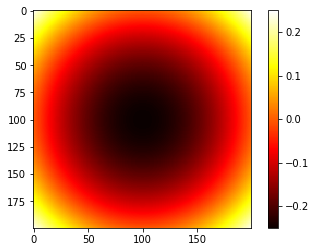

0.098049999999999998

In [35]:
#torch.save(model.state_dict(), '2/model.pkl')
draw_graph()
cal_loss()